In [1]:
import os 
os.chdir("..") 
print(os.getcwd())

/Users/282066/Documents/PHD/Importance Sampling/project-root


In [ ]:
from scipy.io import loadmat
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

from src.importance_sampling.sampling import ImportanceSampler
from src.utils.analysis_utils import prepare_embeddings, summarize_all_metrics
from src.utils.visualisation import plot_metric_bars, plot_pca_tripanel_hexbin, plot_pca_joint_kde, plot_two_panel_barplot


/Users/282066/Documents/PHD/Importance Sampling/project-root/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set paths
DATA_PATH = "data/processed/sentiment_combined.pkl"

In [4]:
# Load data
df = pd.read_pickle(DATA_PATH)
print(f"Loaded {len(df)} rows")

Loaded 381738 rows


In [5]:
df.columns

Index(['text', 'label', 'len', 'source', 'label_text', 'cls_embedding',
       'mean_embedding', 'predicted_label', 'pred_label'],
      dtype='object')

In [6]:
# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality

features = "cls_embedding"  # or "mean_embedding"
use_pca = True  # toggle between full embedding or PCA

df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca, n_components=5)

Applying PCA to reduce from 768 to 5 dimensions...
Total variance explained by 5 components: 85.19%


In [7]:
# Define domains
df_source = df[df["source"].str.contains("amazon_test")]
df_target = df[df["source"].str.contains("tweeteval_test")]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 375483 samples
Target: 6255 samples


In [8]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = ['text', 'len', 'label', 'label_text', 'source', 'cls_embedding',
       'mean_embedding', 'predicted_label_text', 'predicted_label', 'pred_label']

In [9]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)

Current best logistic target prob avg at iter 1: 0.106


In [10]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df = summarize_all_metrics(datasets, label_col='label', pred_col='pred_label', 
                                   n_bootstrap=100, average = 'weighted')
print(results_df)

        set     metric      mean     lower     upper
0    Source  precision  0.945861  0.945289  0.946585
1    Source     recall  0.943516  0.942900  0.944287
2    Target  precision  0.805340  0.797655  0.813063
3    Target     recall  0.712499  0.703673  0.721990
4    Sample  precision  0.780438  0.755873  0.802052
5    Sample     recall  0.732750  0.701950  0.757000
6  Weighted  precision  0.790233  0.783391  0.795970
7  Weighted     recall  0.739098  0.730066  0.746907


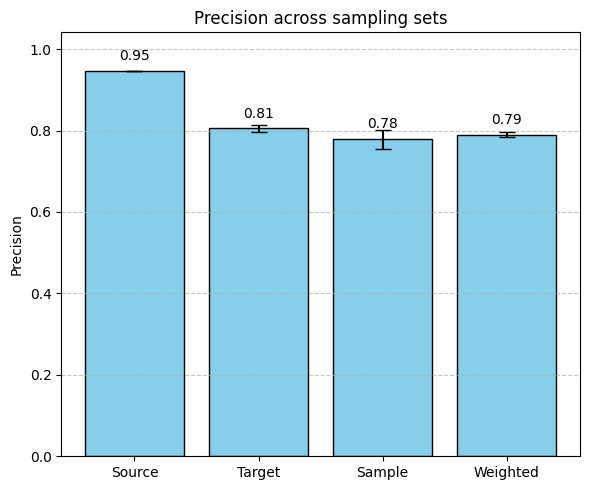

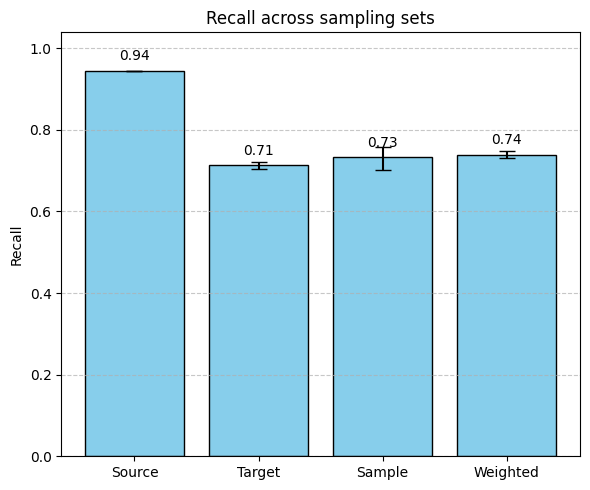

In [11]:
# Plot metrics
plot_metric_bars(results_df, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df, metric="recall", title="Recall across sampling sets")

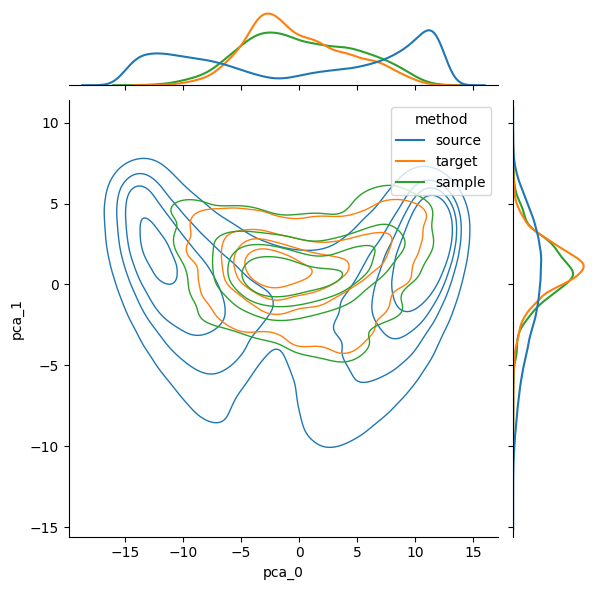

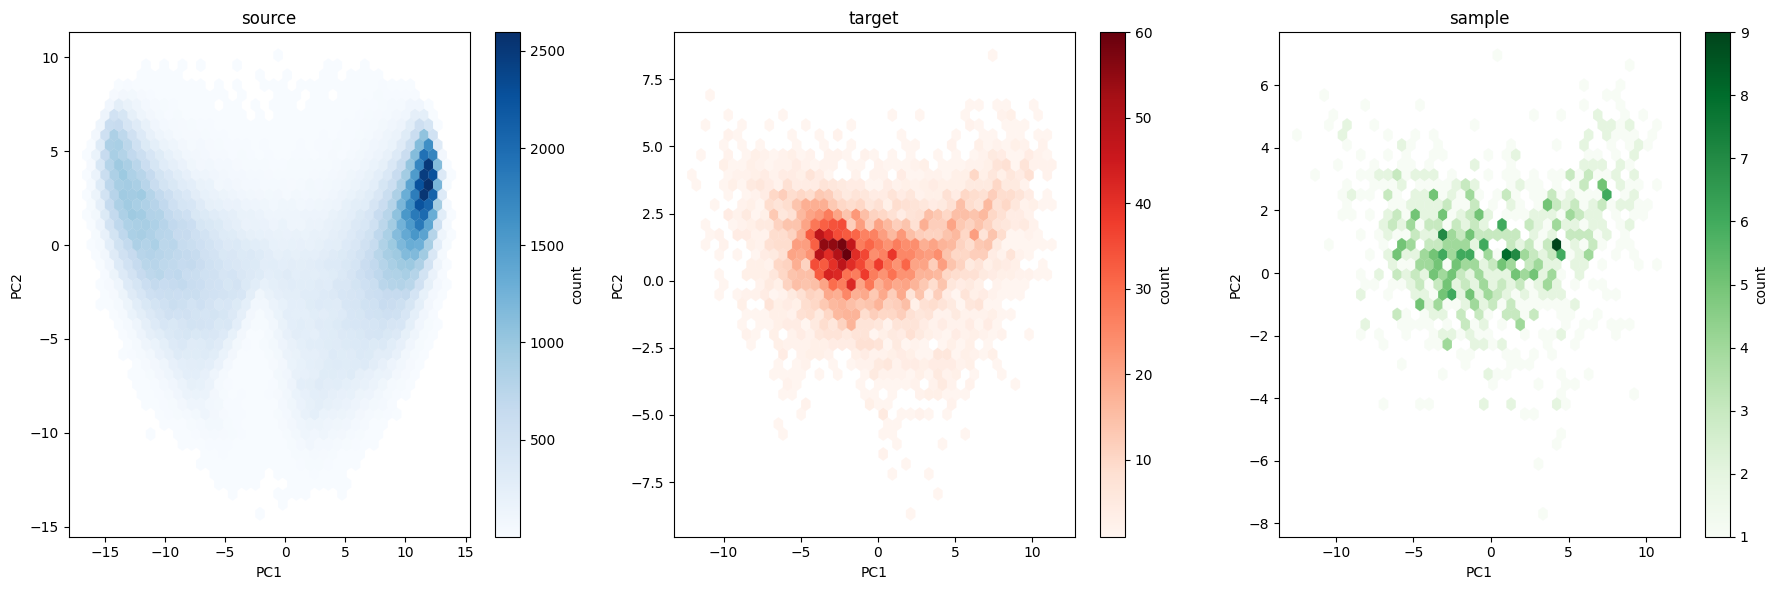

In [12]:
plot_pca_joint_kde(df_source, df_target, df_sample, ignore_cols=ignore_columns)
plot_pca_tripanel_hexbin(df_source, df_target, df_sample, ignore_cols=ignore_columns)

### Label shift

In [14]:
df = pd.read_pickle(DATA_PATH)

# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality

features = "cls_embedding"  # or "mean_embedding"
use_pca = True  # toggle between full embedding or PCA

df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca, n_components=5)

Applying PCA to reduce from 768 to 5 dimensions...
Total variance explained by 5 components: 85.19%


In [15]:
df_target_0 = df[df["source"].str.contains("tweeteval_test") & (df['label_text'] == 'negative' ) ]
df_target_1 = df[df["source"].str.contains("tweeteval_test") & (df['label_text'] == 'positive' ) ]
df_target = pd.concat([
    df_target_0.sample(n=1600, random_state =42),
    df_target_1.sample(n=400, random_state =42)
]).reset_index(drop=True)

df_source = df[df["source"].str.contains("amazon_test")
               & (~df['text'].isin(df_target['text']))]

In [16]:
print(df_source['label'].mean(), df_source['pred_label'].mean())
print(df_target['label'].mean(), df_target['pred_label'].mean())

0.5179914936228804 0.5552927828956304
0.2 0.5345


In [17]:
n_components = 500
embeddings = [f'embedding_{i}' for i in range(n_components)]

n_components = 10
pca_components = [f'pca_{i}' for i in range(n_components)]

In [18]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = ['text', 'len', 'label_text', 'source', 'cls_embedding',
       'mean_embedding', 'predicted_label_text', 'predicted_label', 'predicted_label', 'label', 'pred_label']

### Without rescaling for label shift

Current best logistic target prob avg at iter 1: 0.074


<Axes: title={'center': 'pca_4'}, xlabel='pca_4', ylabel='Density'>

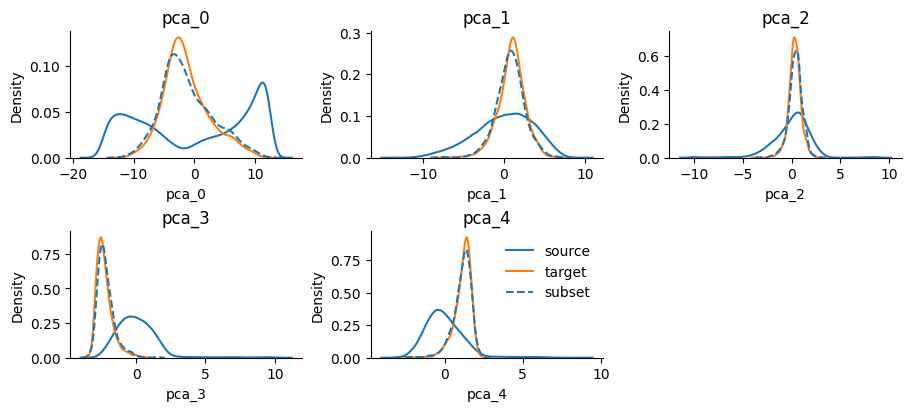

In [19]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS, 
                                       )
imp.plot(df_sample, maxcols=3) 

In [20]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df = summarize_all_metrics(datasets, label_col='label', pred_col='pred_label', 
                                   n_bootstrap=1000, average = 'binary')
print(results_df)

        set     metric      mean     lower     upper
0    Source  precision  0.915579  0.914394  0.916741
1    Source     recall  0.981484  0.980906  0.982077
2    Target  precision  0.351928  0.324340  0.379982
3    Target     recall  0.940415  0.916662  0.963508
4    Sample  precision  0.528280  0.488883  0.568353
5    Sample     recall  0.868706  0.827981  0.903925
6  Weighted  precision  0.538670  0.520772  0.556120
7  Weighted     recall  0.875513  0.860640  0.890136


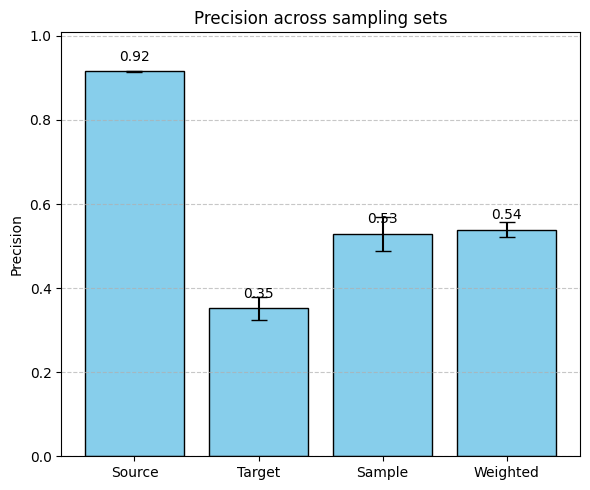

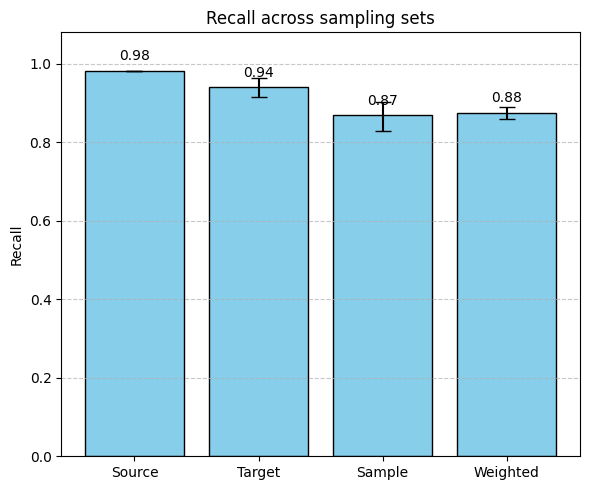

In [21]:
# Plot metrics
plot_metric_bars(results_df, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df, metric="recall", title="Recall across sampling sets")

### With rescaling for label shift

In [22]:
df_target['label'].mean()

np.float64(0.2)

Current best logistic target prob avg at iter 1: 0.079


<Axes: title={'center': 'pca_4'}, xlabel='pca_4', ylabel='Density'>

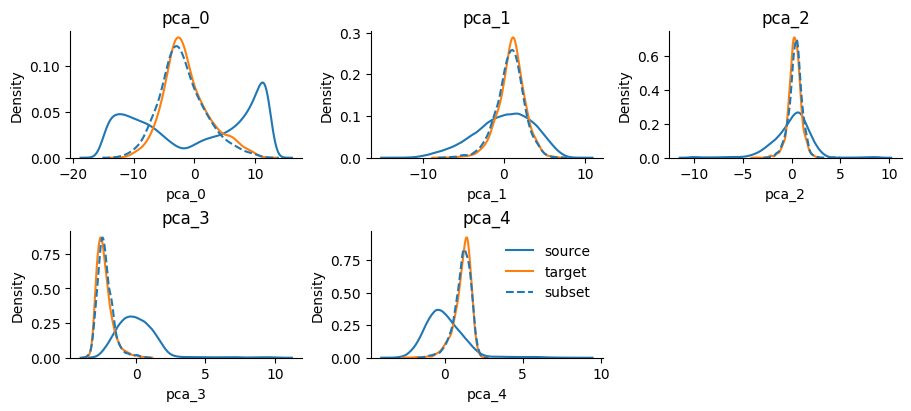

In [23]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS, 
                                       frac_y_1= 0.2,
                                       label_col='label')
imp.plot(df_sample, maxcols=3) 

In [24]:
df_sample['label'].mean()

np.float64(0.194)

In [26]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df_2 = summarize_all_metrics(datasets, label_col='label', pred_col='pred_label', 
                                   n_bootstrap=1000, average = 'binary')
print(results_df_2)

        set     metric      mean     lower     upper
0    Source  precision  0.915579  0.914394  0.916741
1    Source     recall  0.981484  0.980906  0.982077
2    Target  precision  0.351928  0.324340  0.379982
3    Target     recall  0.940415  0.916662  0.963508
4    Sample  precision  0.357790  0.315680  0.402409
5    Sample     recall  0.921889  0.883331  0.956528
6  Weighted  precision  0.361138  0.344673  0.377484
7  Weighted     recall  0.875513  0.860640  0.890136


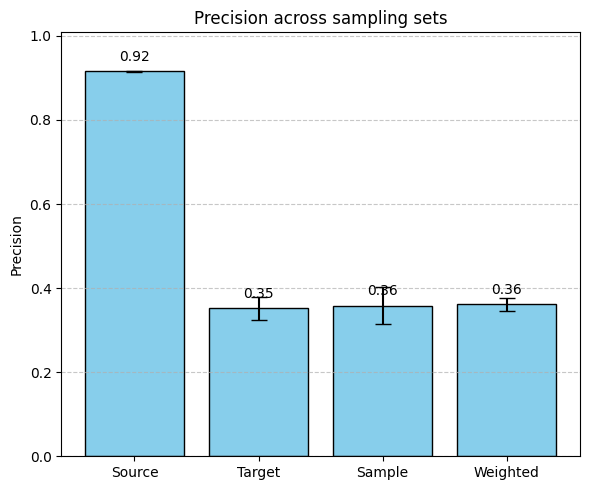

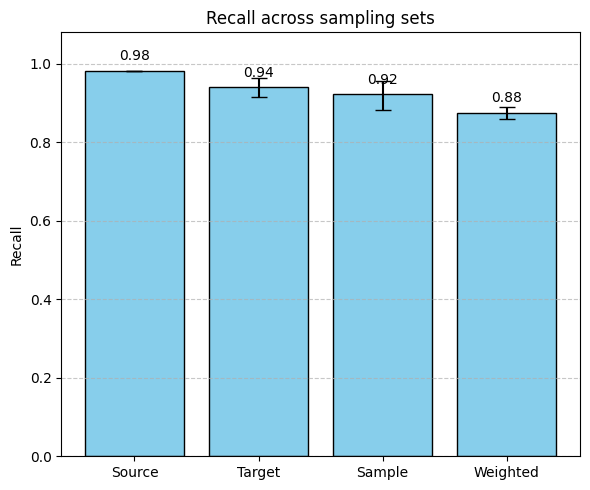

In [27]:
# Plot metrics
plot_metric_bars(results_df_2, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df_2, metric="recall", title="Recall across sampling sets")

### Rescaling based on yhat in stead of y in case of a well calibrated model 

In [176]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = ['text', 'len', 'label_text', 'source', 'cls_embedding',
       'mean_embedding', 'predicted_label_text', 'predicted_label', 'predicted_label', 'label', 'pred_label']

In [177]:
df_target['pred_label'].mean()

np.float64(0.5345)

Current best logistic target prob avg at iter 1: 0.067


<Axes: title={'center': 'pca_4'}, xlabel='pca_4', ylabel='Density'>

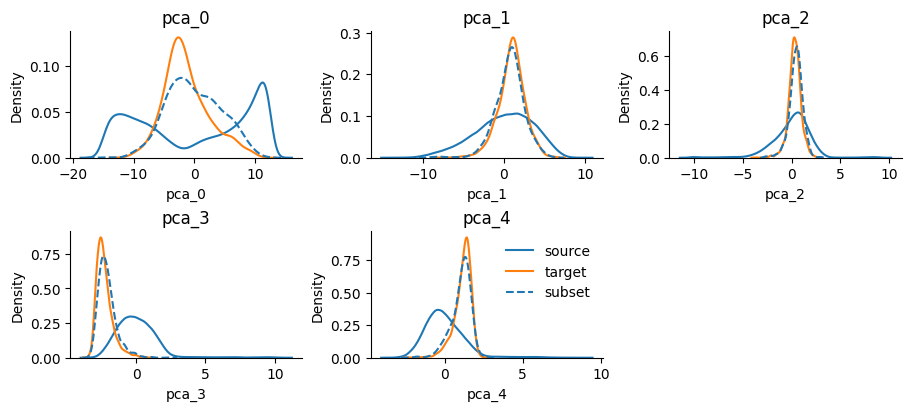

In [178]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS,
                                       frac_y_1= 0.53,
                                       label_col='label')
imp.plot(df_sample, maxcols=3) 

In [179]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df_3 = summarize_all_metrics(datasets, label_col='label', pred_col='pred_label', 
                                   n_bootstrap=100, average = 'binary')
print(results_df_3)

        set     metric      mean     lower     upper
0    Source  precision  0.915556  0.914495  0.916685
1    Source     recall  0.981476  0.980890  0.981940
2    Target  precision  0.353201  0.324686  0.380600
3    Target     recall  0.941746  0.921543  0.963866
4    Sample  precision  0.721769  0.689453  0.755224
5    Sample     recall  0.901385  0.877992  0.926328
6  Weighted  precision  0.719291  0.706095  0.733677
7  Weighted     recall  0.875694  0.863569  0.888058


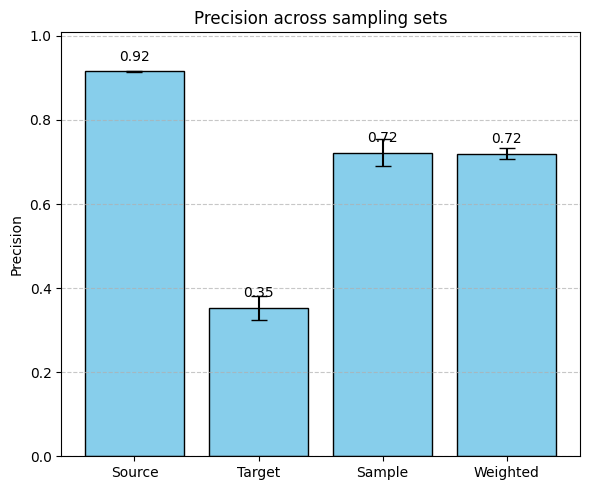

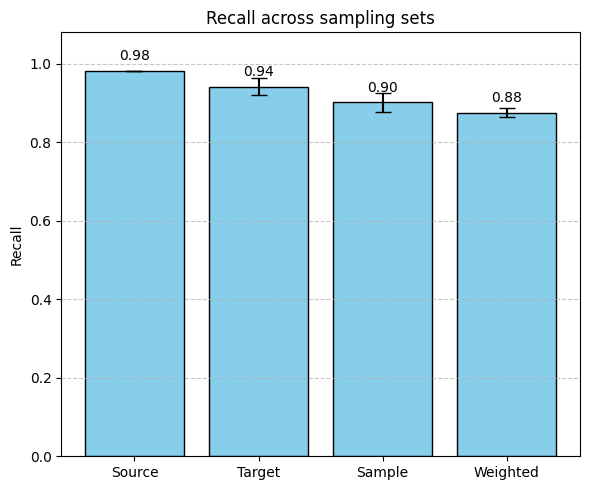

In [180]:
# Plot metrics
plot_metric_bars(results_df_3, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df_3, metric="recall", title="Recall across sampling sets")

### summary plot 

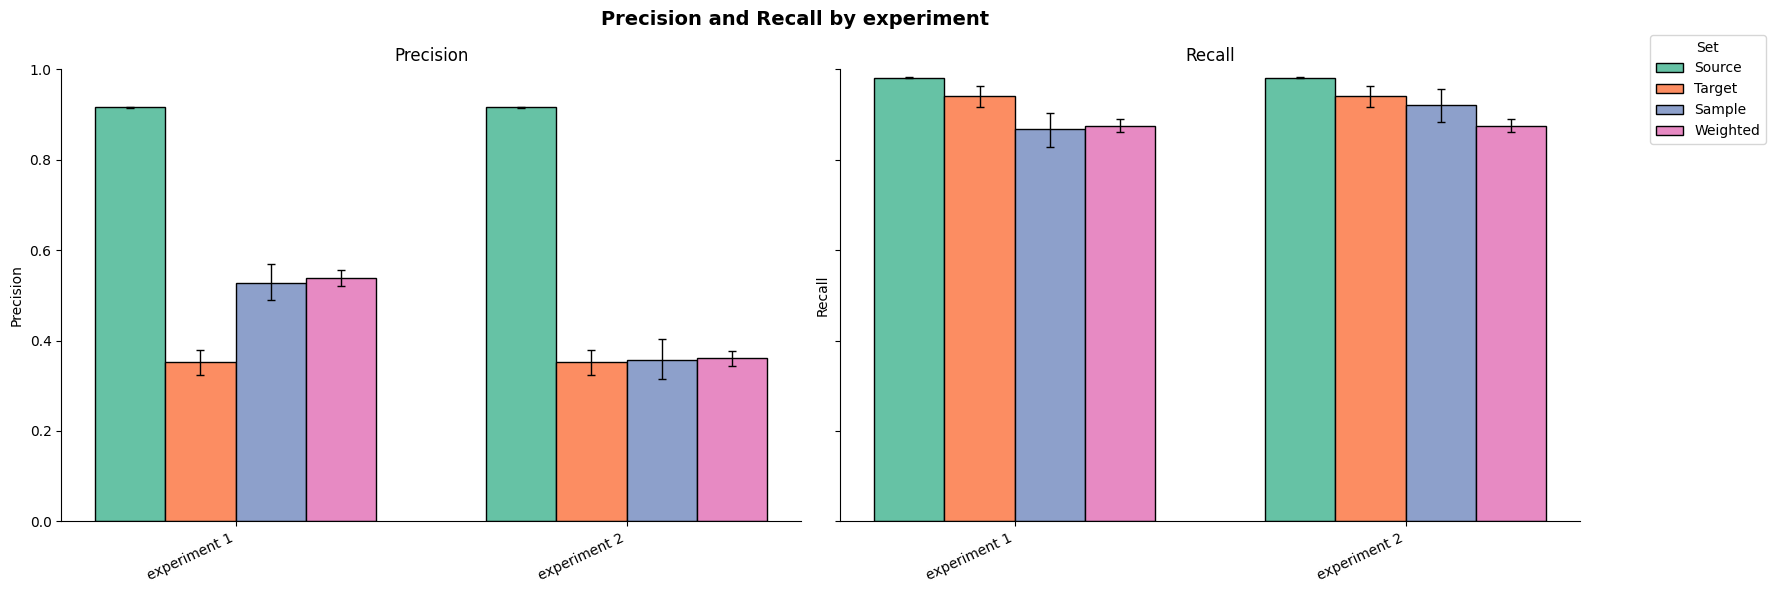

In [28]:
results = {
    "Label shift - PCA weighting no rescaling": results_df,
    "Label shift - PCA weighting + rescaling on P(Y)": results_df_2,
}

results = {
    "experiment 1": results_df,
    "experiment 2": results_df_2,
}

plot_two_panel_barplot(
    results)
plt.show()
